In [ ]:
# This information helps with debugging and getting support :)
import sys, platform
import pandas as pd
import bifacial_radiance as br
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("bifacial_radiance version ", br.__version__)

# 11 - AgriPV Systems

This journal shows how to model an AgriPV site, calculating the irradiance not only on the modules but also the irradiance received by the ground to evaluate available solar ersource for plants. 

We assume that bifacia_radiacne is already installed in your computer. This works for bifacial_radiance v.3 release.

These journal outlines 4 useful uses of bifacial_radiance and some tricks: 

* Creating the modules in the AgriPV site
* Adding extra geometry for the pillars/posts supporting the AgriPV site
* Hacking the sensors to sample the ground irradiance and create irradiance map
* Adding object to simulate variations in ground albedo from different crops between rows.


#### Steps:

1. <a href='#step1'> Generate the geometry </a>
2. <a href='#step2'> Analyse the Ground Irradiance </a>
3. <a href='#step3'> Analyse and MAP the Ground Irradiance </a>
4. <a href='#step4'> Adding different Albedo Section </a>
    
#### Preview of what we will create: 
    
![Another view](../images_wiki/AdvancedJournals/AgriPV_2.PNG)
![AgriPV Image We will create](../images_wiki/AdvancedJournals/AgriPV_1.PNG)
And this is how it will look like:

![AgriPV modeled step 4](../images_wiki/AdvancedJournals/AgriPV_step4.PNG)




<a id='step1'></a>

## 1. Generate the geometry 

This section goes from setting up variables to making the OCT axis. We are also adding some custom elements for the torquetubes and posts.

We've done this before a couple times, no new stuff here. 

The magic is that, for doing the carport we see in the figure, we are going to do a 4-up configuration of modules (**numpanels**), and we are going to repeat that 3-UP 6 times (**nMods**)

In [1]:
import os
from pathlib import Path

testfolder = str(Path().resolve().parent.parent / 'bifacial_radiance' / 'TEMP' /  'Tutorial_11')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)
    
print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in C:\Users\cdeline\Documents\Python Scripts\Bifacial_Radiance\bifacial_radiance\TEMP\Tutorial_11


In [2]:
import bifacial_radiance as br
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
simulationname = 'tutorial_11'

#Location:
lat = 40.0583  # NJ
lon = -74.4057  # NJ

# MakeModule Parameters
moduletype='test-module'
numpanels = 3  # AgriPV site has 3 modules along the y direction (N-S since we are facing it to the south) .
x = 0.95  
y = 1.95
xgap = 2.0# Leaving 15 centimeters between modules on x direction
ygap = 0.10 # Leaving 10 centimeters between modules on y direction
zgap = 0 # no gap to torquetube.
sensorsy = 6*numpanels  # this will give 6 sensors per module, 1 per cell

# Other default values:

# TorqueTube Parameters
axisofrotationTorqueTube=False  # this is False by default if there is no torquetbue parameters
torqueTube = False
cellLevelModule = True

numcellsx = 12
numcellsy = 6
xcell = 0.156
ycell = 0.156
xcellgap = 0.02
ycellgap = 0.02

cellLevelModuleParams = {'numcellsx': numcellsx, 'numcellsy':numcellsy, 
                         'xcell': xcell, 'ycell': ycell, 'xcellgap': xcellgap, 'ycellgap': ycellgap}

# SceneDict Parameters
pitch = 15 # m
albedo = 0.2  #'grass'     # ground albedo
hub_height = 4.3 # m  
nMods = 6 # six modules per row.
nRows = 3  # 3 row

azimuth_ang=180 # Facing south
tilt =35 # tilt. 

# Now let's run the example

demo = br.RadianceObj(simulationname,path = testfolder)  
demo.setGround(albedo) 
epwfile = demo.getEPW(lat, lon) # NJ lat/lon 40.0583° N, 74.4057
metdata = demo.readWeatherFile(epwfile, coerce_year=2001) 
timestamp = metdata.datetime.index(pd.to_datetime('2001-06-17 13:0:0 -5'))  # Make this timezone aware, use -5 for EST.
demo.gendaylit(timestamp)  


# Making module with all the variables
module=demo.makeModule(name=moduletype,x=x,y=y,numpanels=numpanels, 
                           xgap=xgap, ygap=ygap, cellModule=cellLevelModuleParams)
# create a scene with all the variables
sceneDict = {'tilt':tilt,'pitch': 15,'hub_height':hub_height,'azimuth':azimuth_ang, 'nMods': nMods, 'nRows': nRows}  
scene = demo.makeScene(module=moduletype, sceneDict=sceneDict) 
octfile = demo.makeOct(demo.getfilelist())


path = C:\Users\cdeline\Documents\Python Scripts\Bifacial_Radiance\bifacial_radiance\TEMP\Tutorial_11
Loading albedo, 1 value(s), 0.200 avg
1 nonzero albedo values.
Getting weather file: USA_NJ_McGuire.AFB.724096_TMY3.epw
 ... OK!
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2001
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos

Module Name: test-module
Module was shifted by 0.078 in X to avoid sensors on air
This is a Cell-Level detailed module with Packaging Factor of 0.81 
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created tutorial_11.oct


If desired, you can view the Oct file at this point:

***rvu -vf views\front.vp -e .01 tutorial_11.oct***

In [4]:

## Comment the ! line below to run rvu from the Jupyter notebook instead of your terminal.
## Simulation will stop until you close the rvu window

#!rvu -vf views\front.vp -e .01 tutorial_11.oct



And adjust the view parameters, you should see this image.

![AgriPV modeled step 1](../images_wiki/AdvancedJournals/AgriPV_step1.PNG)


### Adding the structure

We will add on the torquetube and pillars.

Positions of the piles could be done more programatically, but they are kinda estimated at the moment. 

In [5]:
torquetubelength = module.scenex*(nMods) 

name='Post1'
text='! genbox Metal_Aluminum_Anodized torquetube_row1 {} 0.2 0.3 | xform -t {} -0.1 -0.3 | xform -t 0 0 4.2'.format(
                                                    torquetubelength, (-torquetubelength+module.sceney)/2.0)
customObject = demo.makeCustomObject(name,text)
scene.appendtoScene(radfile=scene.radfiles[0],customObject=customObject)

name='Post2'
text='! genbox Metal_Aluminum_Anodized torquetube_row2 {} 0.2 0.3 | xform -t {} -0.1 -0.3 | xform -t 0 15 4.2'.format(
                                            torquetubelength, (-torquetubelength+module.sceney)/2.0)
customObject = demo.makeCustomObject(name,text)
scene.appendtoScene(customObject=customObject)

name='Post3'
text='! genbox Metal_Aluminum_Anodized torquetube_row2 {} 0.2 0.3 | xform -t {} -0.1 -0.3 | xform -t 0 -15 4.2'.format(
                                              torquetubelength, (-torquetubelength+module.sceney)/2.0)
customObject = demo.makeCustomObject(name,text)
scene.appendtoScene(customObject=customObject)



Custom Object Name objects\Post1.rad

Custom Object Name objects\Post2.rad

Custom Object Name objects\Post3.rad


In [6]:
name='Pile'
pile1x = (torquetubelength+module.sceney)/2.0
pilesep = pile1x*2.0/7.0

text= '! genrev Metal_Grey tube1row1 t*4.2 0.15 32 | xform -t {} 0 0'.format(pile1x)
text += '\r\n! genrev Metal_Grey tube1row2 t*4.2 0.15 32 | xform -t {} 15 0'.format(pile1x)
text += '\r\n! genrev Metal_Grey tube1row3 t*4.2 0.15 32 | xform -t {} -15 0'.format(pile1x)

for i in range (1, 7):
    text += '\r\n! genrev Metal_Grey tube{}row1 t*4.2 0.15 32 | xform -t {} 0 0'.format(i+1, pile1x-pilesep*i)
    text += '\r\n! genrev Metal_Grey tube{}row2 t*4.2 0.15 32 | xform -t {} 15 0'.format(i+1, pile1x-pilesep*i)
    text += '\r\n! genrev Metal_Grey tube{}row3 t*4.2 0.15 32 | xform -t {} -15 0'.format(i+1, pile1x-pilesep*i)

customObject = demo.makeCustomObject(name,text)
scene.appendtoScene( customObject=customObject)

octfile = demo.makeOct()  # makeOct combines all of the ground, sky and object files we just added into a .oct file.


Custom Object Name objects\Pile.rad
Created tutorial_11.oct


### View the geometry with the posts on :

***rvu -vf views\front.vp -e .01 -pe 0.4 -vp 12 -10 3.5 -vd -0.0995 0.9950 0.0 tutorial_11.oct***



In [7]:

## Comment the ! line below to run rvu from the Jupyter notebook instead of your terminal.
## Simulation will stop until you close the rvu window

#!rvu -vf views\front.vp -e .01 tutorial_11.oct



![AgriPV modeled step 2](../images_wiki/AdvancedJournals/AgriPV_step2.PNG)

<a id='step2'></a>

## 2. Analyse  the Ground Irradiance

Now let's do some analysis along the ground, starting from the edge of the modules. We wil select to start in the center of the array.

We are also increasign the number of points sampled accross the collector width, with the  variable **sensorsy** passed to **moduleanalysis**. We are also increasing the step between sampling points, to be able to sample in between the rows.

**We'll use the new `AnalysisObj.groundAnalysis()` function starting in v0.5.0 to determine the scan points on the ground.**

In [8]:
analysis = br.AnalysisObj(octfile, demo.name)  
sensorsy = 20
frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)
groundscan = analysis.groundAnalysis(scene, sensorsground=sensorsy)
groundscan

{'xstart': np.float16(0.0),
 'ystart': np.float16(0.0),
 'zstart': np.float16(0.05),
 'xinc': np.float16(0.0),
 'yinc': np.float16(-0.7896),
 'zinc': np.float16(0.0),
 'sx_xinc': 0.0,
 'sx_yinc': 0.0,
 'sx_zinc': 0.0,
 'Nx': 1,
 'Ny': 20,
 'Nz': 1,
 'orient': '0 0 -1'}

In [9]:
analysis.analysis(octfile, simulationname+"_scan", groundscan)  # compare the back vs front irradiance  


Linescan in process: tutorial_11_scan_Row2_Module3_Front
Saved: results\irr_tutorial_11_scan_Row2_Module3.csv


{'Wm2': array([332.89396667, 691.32513333, 715.60123333, 735.5388    ,
        744.5296    , 749.1159    , 750.81526667, 752.03366667,
        751.96643333, 747.43736667, 743.95496667, 738.61256667,
        734.60366667, 723.0667    , 708.3394    , 696.8361    ,
        342.9871    , 323.97993333, 317.4839    , 337.0623    ]),
 'x': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 'y': array([  0.    ,  -0.7896,  -1.579 ,  -2.37  ,  -3.158 ,  -3.947 ,
         -4.74  ,  -5.527 ,  -6.316 ,  -7.105 ,  -7.895 ,  -8.69  ,
         -9.48  , -10.266 , -11.055 , -11.84  , -12.63  , -13.42  ,
        -14.21  , -15.    ]),
 'z': array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]),
 'r': array([332.7998, 691.1785, 715.4303, 735.3883, 744.4058, 749.002 ,
        750.7009, 751.9545, 751.8872, 747.358 , 743.8846, 738.5325,
        734.5281, 722.988 , 708.2579, 696.735

This is the result for only one 'chord' accross the ground. Let's now do a X-Y scan of the ground.

<a id='step3'></a>

## 3. Analyse and MAP the Ground Irradiance

 We will use the same technique to find the irradiance on the ground used above, but will move it along the X-axis to map from the start of one module to the next.
 
 We will sample around the module that is placed at the center of the field.

![AgriPV modeled step 4](../images_wiki/AdvancedJournals/spacing_between_modules.PNG)

In [10]:
# Use the groundAnalysis function released in bifacial_radiance v0.5.0. With sensorsx=20 it will be a 2D scan.

groundscan = analysis.groundAnalysis(scene, sensorsground=50, sensorsgroundx=50, modWanted=3)
groundscan['ystart'] = scene.sceneDict['pitch'] / 3   # start the scan in the middle of the row for better visualization
groundscan['yinc'] = groundscan['yinc']/2 # zoom in for higher resolution scan
print(groundscan)


{'xstart': np.float16(0.0), 'ystart': 5.0, 'zstart': np.float16(0.05), 'xinc': np.float16(0.0), 'yinc': np.float16(-0.1531), 'zinc': np.float16(0.0), 'sx_xinc': np.float64(0.08023529411764706), 'sx_yinc': np.float64(9.825989611982292e-18), 'sx_zinc': 0.0, 'Nx': 50, 'Ny': 50, 'Nz': 1, 'orient': '0 0 -1'}


In [11]:
analysis.analysis(octfile, simulationname+"_scan_xy", groundscan)  # only need to pass a front groundscan 

Linescan in process: tutorial_11_scan_xy_Row2_Module3_Front
Saved: results\irr_tutorial_11_scan_xy_Row2_Module3.csv


{'Wm2': array([726.9225    , 725.8793    , 724.83606667, ..., 729.0038    ,
        732.92426667, 737.66856667], shape=(2500,)),
 'x': array([0.      , 0.      , 0.      , ..., 3.931529, 3.931529, 3.931529],
       shape=(2500,)),
 'y': array([ 5.      ,  4.847656,  4.695312, ..., -2.195312, -2.347656,
        -2.5     ], shape=(2500,)),
 'z': array([0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05], shape=(2500,)),
 'r': array([726.8588, 725.8158, 724.7727, ..., 728.8752, 732.791 , 737.5244],
       shape=(2500,)),
 'g': array([726.9164, 725.8732, 724.83  , ..., 728.9965, 732.9161, 737.6588],
       shape=(2500,)),
 'b': array([726.9923, 725.9489, 724.9055, ..., 729.1397, 733.0657, 737.8225],
       shape=(2500,)),
 'mattype': array(['groundplane', 'groundplane', 'groundplane', ..., 'groundplane',
        'groundplane', 'groundplane'], shape=(2500,), dtype='<U32'),
 'title': 'tutorial_11_scan_xy_Row2_Module3_Front'}

read the results file

In [12]:
filename = os.path.join(testfolder, 'results','irr_tutorial_11_scan_xy_Row2_Module3.csv')
resultsDF = br.load.read1Result(filename)

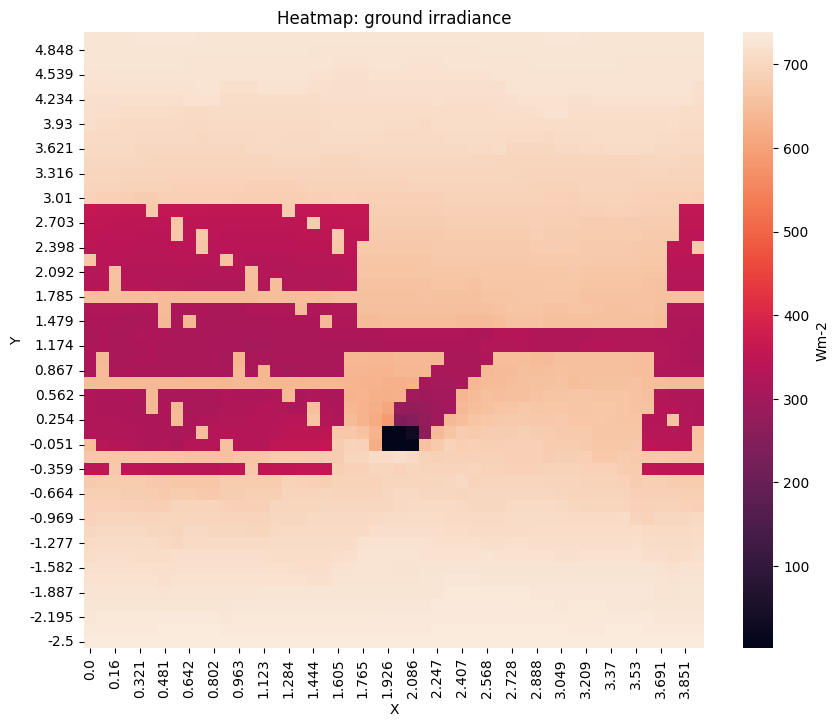

In [14]:
# Create a pivot table to reshape data into a grid
heatmap_data = resultsDF.pivot_table(index='y', columns='x', values='Wm2Front', aggfunc='mean')
plt.figure(figsize=(10, 8))
#plt.imshow(heatmap_data,  aspect='auto', origin='lower')  # imshow doesn't preserve correct x and y coordinates.
#plt.colorbar(label='Wm-2')
ax = sns.heatmap(heatmap_data, cbar_kws={'label': 'Wm-2'})
ax.invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap: ground irradiance')
plt.show()

In [ ]:
## Deprecated method, but still works.
sensorsx = 20
startgroundsample=-module.scenex
spacingbetweensamples = module.scenex/(sensorsx-1)

for i in range (0, sensorsx): # Will map 20 points    
    frontscan, backscan = analysis.moduleAnalysis(scene, sensorsy=sensorsy)
    groundscan = frontscan
    groundscan['zstart'] = 0.05  # setting it 5 cm from the ground.
    groundscan['zinc'] = 0   # no tilt necessary. 
    groundscan['yinc'] = pitch/(sensorsy-1)   # increasing spacing so it covers all distance between rows
    groundscan['xstart'] = startgroundsample + i*spacingbetweensamples   # increasing spacing so it covers all distance between rows
    analysis.analysis(octfile, simulationname+"_groundscan_"+str(i), groundscan, backscan)  # compare the back vs front irradiance  

In [ ]:
filestarter = "irr_tutorial_11_groundscan_"

filelist = sorted(os.listdir(os.path.join(testfolder, 'results')))
prefixed = [filename for filename in filelist if filename.startswith(filestarter)]
arrayWm2Front = []
arrayMatFront = []
filenamed = []
faillist = []

print('{} files in the directory'.format(filelist.__len__()))
print('{} groundscan files in the directory'.format(prefixed.__len__()))
i = 0  # counter to track # files loaded.

for i in range (0, len(prefixed)):
    ind = prefixed[i].split('_')

    try:
        resultsDF = br.load.read1Result(os.path.join(testfolder, 'results', prefixed[i]))
        arrayWm2Front.append(list(resultsDF['Wm2Front']))
        arrayMatFront.append(list(resultsDF['mattype']))
        filenamed.append(prefixed[i])
    except:
        print(" FAILED ", i, prefixed[i])
        faillist.append(prefixed[i])

resultsdf = pd.DataFrame(list(zip(arrayWm2Front, 
                                  arrayMatFront)),
                         columns = ['br_Wm2Front', 
                                    'br_MatFront'])
resultsdf['filename'] = filenamed

Creating a new dataframe where  each element in the front irradiance list is a column. Also transpose and reverse so it looks like a top-down view of the ground.

In [ ]:
df3 = pd.DataFrame(resultsdf['br_Wm2Front'].to_list())
reversed_df = df3.T.iloc[::-1]
sns.set(rc={'figure.figsize':(11.7,8.27)})

         0        1        2        3        4        5        6        7   \
19  707.406  717.969  716.894  714.724  714.243  716.414  712.684  712.545   
18  729.280  732.414  729.824  730.705  729.512  728.390  732.200  729.413   
17  742.290  741.332  741.132  742.073  740.483  742.423  740.617  742.121   
16  748.540  749.139  750.334  747.030  746.692  748.511  748.210  747.987   
15  751.114  750.602  750.646  748.215  751.154  750.184  750.756  748.963   
14  750.900  751.425  750.603  751.448  750.752  749.719  750.619  749.944   
13  749.895  750.598  750.358  750.608  749.556  748.857  749.798  748.299   
12  749.067  747.934  746.706  748.213  748.873  747.933  745.351  747.451   
11  747.113  743.653  745.578  743.618  744.040  745.298  742.976  745.138   
10  740.553  740.609  740.436  740.262  741.033  741.978  740.426  741.833   
9   737.209  736.845  736.907  736.815  737.291  736.247  734.540  736.351   
8   729.293  729.673  727.995  728.887  726.439  725.763  728.75

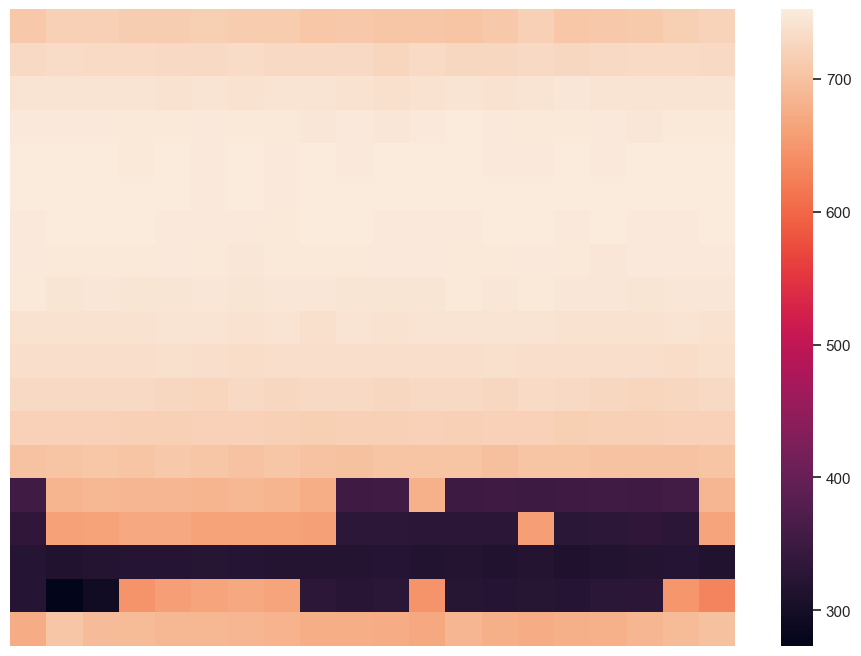

In [68]:
# Plot
print(reversed_df)
ax = sns.heatmap(reversed_df[-20:-1])
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel('')  
ax.set_xlabel('')  
print('')

<a id='step4'></a>

## 4. Adding different Albedo Sections
Add a surface (just like we added the pillars) with a specific reflectivity to represent different albedo sections. In the image, we can see that the albedo between the crops is different than the crop albedo. Let's assume that the abledo between the crops is higher than the crop's albedo which wa previuosly set a 0.2.



In [ ]:
name='Center_Grass'
carpositionx=-2
carpositiony=-1
text='! genbox white_EPDM CenterPatch 28 12 0.1 | xform -t -14 2 0'.format(carpositionx, carpositiony)
customObject = demo.makeCustomObject(name,text)
scene.appendtoScene(customObject)

octfile = demo.makeOct(demo.getfilelist()) 


Viewing with rvu:

![AgriPV modeled step 4](../images_wiki/AdvancedJournals/AgriPV_step4.PNG)

